# H.E.S.S. I

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord

from nsb2.atmosphere import SingleScatteringAtmosphere
from nsb2.core.lightpath import DirectPath, ScatteredPath
from nsb2.core.pipeline import Pipeline
from nsb2.core.solver import (
    LUTDirectSolver,
    LUTScatteredSolver,
)
from nsb2.emitter import airglow, moon, stars, zodiacal
from nsb2.instrument import HESS

## 1.  Creating a model

We create the standard NSB sources, which are airglow, zodiacal light, stars from GaiaDR3 supplemented with XHIP for bright stars and a moonlight model:

In [2]:
# The airglow is taken from eso_skycalc and scaled with emission layer height and SFU value.
glow = airglow.from_eso_skycalc(87*u.km, 100)
# The zodiacal light is from a summary table in leinert1998
zodi = zodiacal.from_leinert1998()

# Bright stars not available in Gaia are takne from the XHIP as a supplementary catalog. there might still be gaps
h_bright = stars.from_gaia_suppl_catalog()
h_bright.build_balltree()

# Stars under mag15 are taken explicitly. here the balltree construction might take some time (32 mio stars)
u_mag15 = stars.from_gaia_dr3_catalog()
u_mag15.build_balltree()
# For in-scattering, we don't want to treat all 32 mio stars explicitly, so we accumulate them in a map.
u_mag15_map = u_mag15.to_map(2**6)
# Stars above magnitude 15 are already accumulated in a map (NSIDE=2**10)
o_mag15 = stars.from_gaia_dr3_map()

# Moon models comes from Noll et al. 2013
noll13 = moon.from_noll2013()

For the atmosphere, we need to defined an airmass function X, as well as rayleight and mie transmission functions + absorption (0 here for simplicity).

In [3]:
def X(Z):
    return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))

def t_r(lam, height):
    return 0.00879*(lam.to(u.micron).value)**-4.09 * np.exp(-height.to(u.km).value/8)

def t_m(lam, height, aero):
    return aero[0]*(lam.to(u.nm).value/380)**(-aero[1]) * np.exp(-height.to(u.km).value/1.54)

def t_a(lam):
    return np.zeros(lam.shape)

atmo = SingleScatteringAtmosphere(X,
                                  lambda x: t_r(x, 8*u.km),
                                  lambda x: t_m(x, 1.8*u.km, [0.5, 1]),
                                  t_a,
                                  0.8)

We can then load one of the telescope models

In [4]:
hess1 = HESS.CT1()

### Compiling the model:
We need to determine which components take which path (Direct and ScatteredPath), and which solver is used to solve the path. We can combine different paths in a central model via operator overload.

In [5]:
model_diff = Pipeline(hess1, atmo, [glow, zodi, noll13],
                      paths=[DirectPath(), ScatteredPath()])

model_star = Pipeline(hess1, atmo, [h_bright, u_mag15, o_mag15],
                      paths=[DirectPath(solver=LUTDirectSolver())])

model_star_scatter = Pipeline(hess1, atmo, [h_bright, u_mag15_map, o_mag15],
                              paths=[ScatteredPath(solver=LUTScatteredSolver())])

# Compose and compile
model = model_star + model_star_scatter + model_diff
model.compile(extinction_z_bins=90, scattering_z_bins=10, scattering_theta_bins=10)

0.0

### Creating an observation:
A "frame" describing a capture is determined by:
 - A location
 - An observation time in UTC
 - A target at which to point
 - The rotation of the telescope around the axis

We make use of the AstroPy AltAz and SkyOffsetFrames. When passing atmospheric parameters, this also automatically calculates the atmospheric refraction:

In [6]:
import astropy
from astropy.coordinates import AltAz, SkyOffsetFrame

rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-06-18T23:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('sgr a*')
base = AltAz(obstime=obstime, location=location,
             pressure=1000*u.hPa, relative_humidity=0.3, temperature=20*u.deg_C)

observation = SkyOffsetFrame(origin=target.transform_to(base), rotation=rotation)

## 2. Using the model to predict NSB
Calling the model is then easy. Depending on your hardware, the amount of sources in your skyfield and simulation fidelity, it might take up to 10s.

In [7]:
%%time
pred = model.predict(observation)

CPU times: user 5.12 s, sys: 1.69 s, total: 6.81 s
Wall time: 6.84 s


The end result is an array of prediction values, one for each source and path. We can look at the first prediction:

In [8]:
pred[0]

Prediction(rates=<Quantity [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]] Hz>, indirect=False, source_name='XHIP_Gaia_Suppl', path_name='DirectPath')

It is important to note the rates predicted by the package have the shape (Npix,3). The 3 axis are min/med/max values respectively. This matters for sources which have multiple possible realizations in their last axis. This enables propagating uncertainties due to model choice through the simulation.

## 3. Visualizing the data:
Visualization is easiest with ctapipe (which you should install for this to work):

In [9]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

cam = CameraGeometry.from_name('HESS-I')
def ctapipe_disp(cam, rates, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = rates
    display.add_colorbar(label=label)
    return display

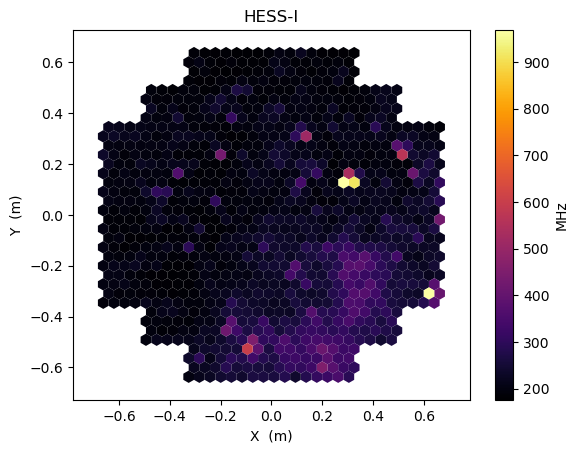

In [10]:
fig, ax = plt.subplots()
p_all = [(p.rates).to(u.MHz)[:,1] for p in pred]
disp = ctapipe_disp(cam, np.array(p_all).sum(axis=0), ax, label='MHz', show_frame=False)

### Individual contributions:

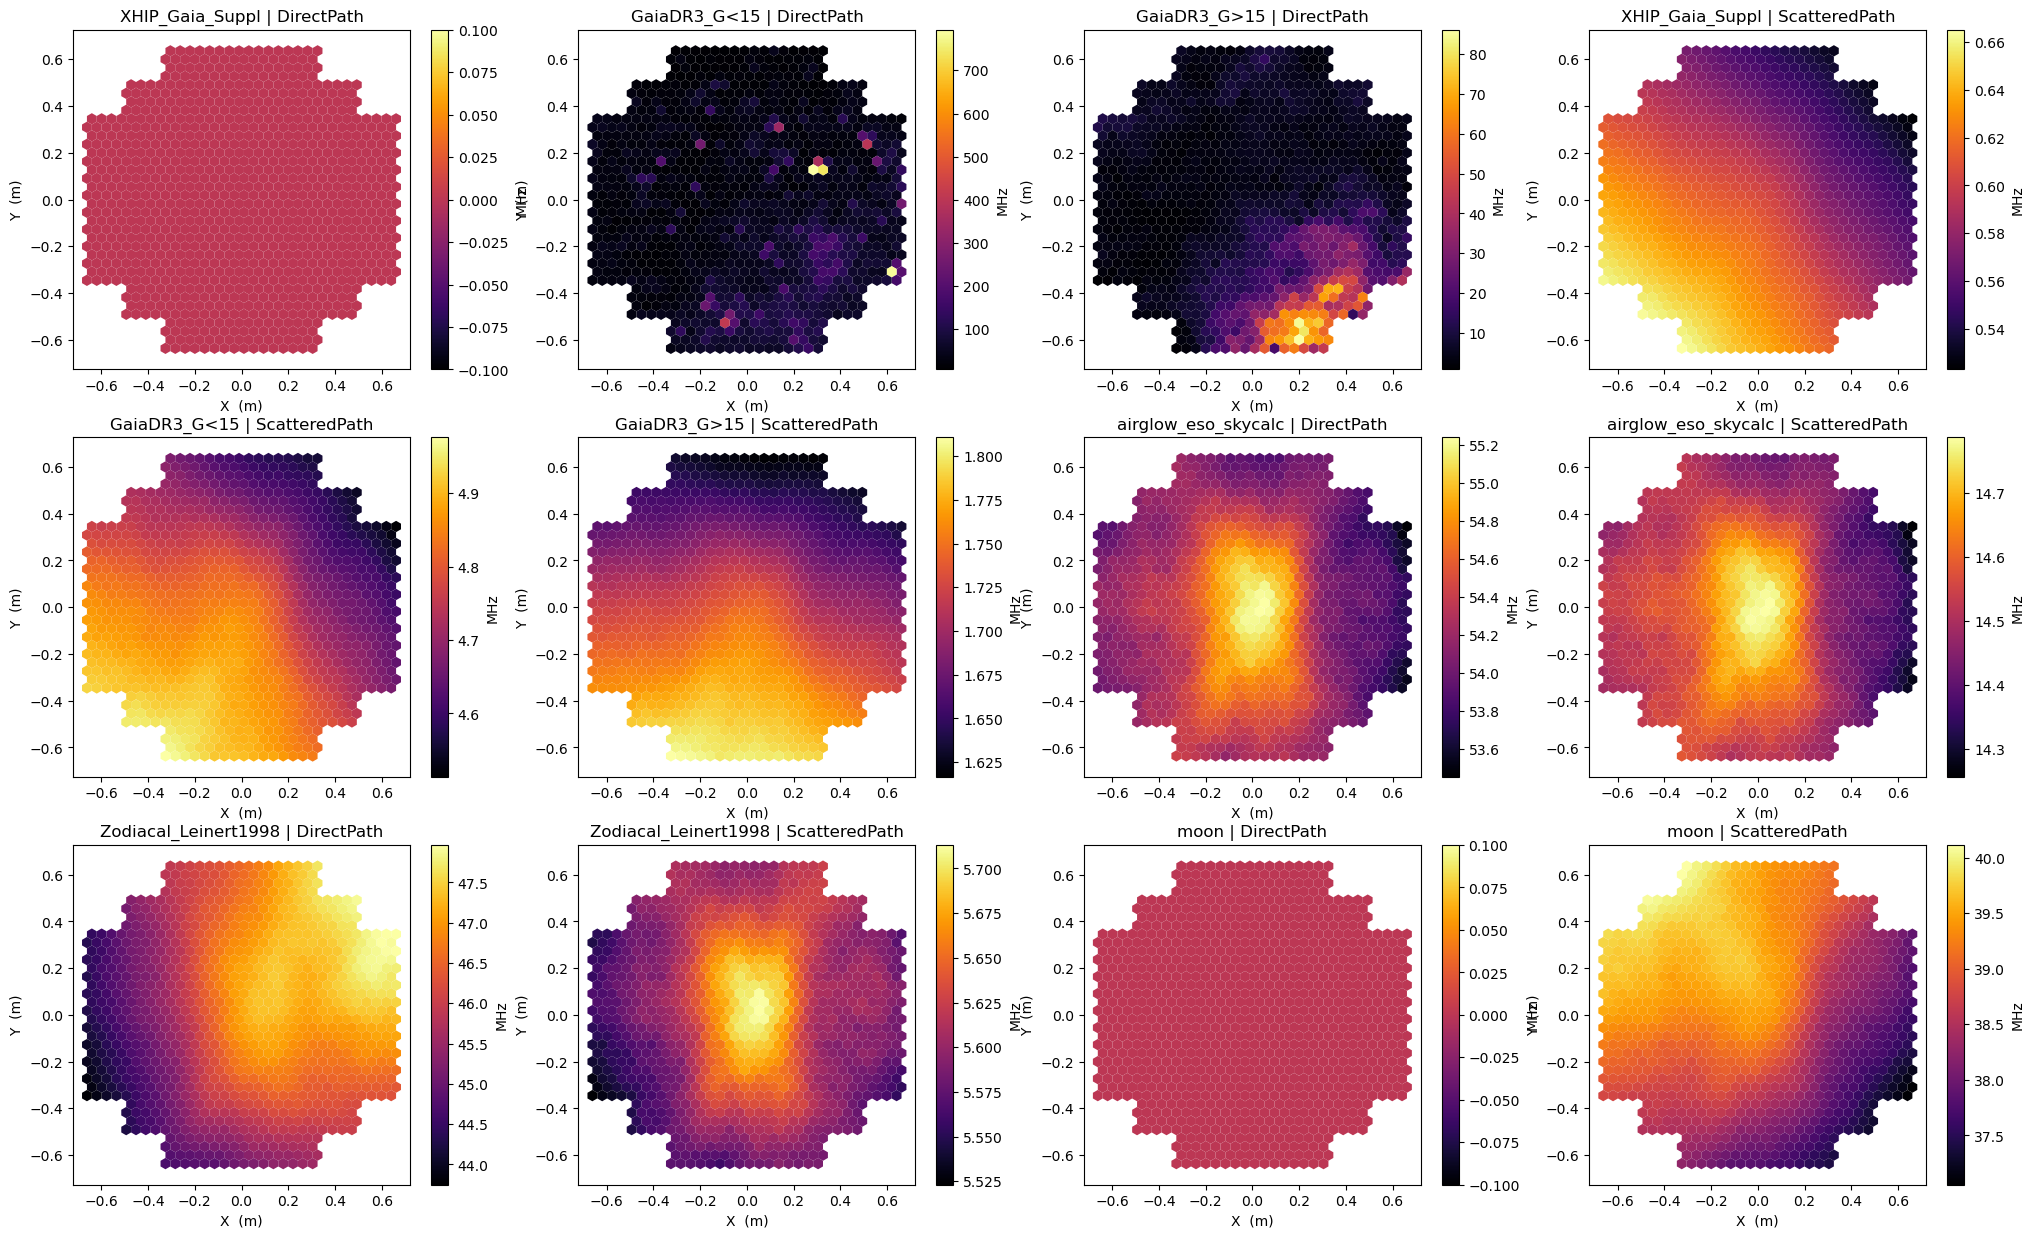

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=(len(pred)-1)//4 + 1, figsize=(25,5*((len(pred)-1)//4 + 1)))
for i in range(len(pred)):
    disp = ctapipe_disp(cam,  pred[i].rates.to(u.MHz)[:,1], ax[i//4,i%4], label='MHz',
                        title=pred[i].source_name +" | " + pred[i].path_name, show_frame=False)